In [1]:
!nvidia-smi

Thu Nov 14 15:33:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.29                 Driver Version: 546.29       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   43C    P0              32W / 170W |    936MiB / 12288MiB |      1%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import sys
import torch
print(sys.version)
print(torch.__version__)

3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]
2.1.2+cu121


# import pyshearlab을 위한 다운로드

In [2]:
#pip install https://github.com/stefanloock/pyshearlab/archive/master.zip

In [3]:
#pip install bm3d

# 필요한 라이브러리 Import

In [3]:
# basic library
import numpy as np
import random
import math
import pandas as pd
import time
import os
from sklearn.model_selection import train_test_split

# image library
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import pyshearlab

# wavelet library
import pywt

# skimage(result func., noise, denoise_wavelet...)
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage import img_as_float
from skimage.util import random_noise
from skimage.restoration import denoise_wavelet, estimate_sigma

#torch library
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.ops import DeformConv2d
import torchvision



# Cuda 설정

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Wavelet 확인 절차

## Wavelet Func.(pywt.wavelist)

In [5]:
available_wt_func = pywt.wavelist()
print(f'총 Wavelet함수 개수: {len(available_wt_func)}개')

print()
print("Available Wavelets' Function:")
for idx, wt_func in enumerate(available_wt_func):
    print(idx+1, wt_func)

총 Wavelet함수 개수: 127개

Available Wavelets' Function:
1 bior1.1
2 bior1.3
3 bior1.5
4 bior2.2
5 bior2.4
6 bior2.6
7 bior2.8
8 bior3.1
9 bior3.3
10 bior3.5
11 bior3.7
12 bior3.9
13 bior4.4
14 bior5.5
15 bior6.8
16 cgau1
17 cgau2
18 cgau3
19 cgau4
20 cgau5
21 cgau6
22 cgau7
23 cgau8
24 cmor
25 coif1
26 coif2
27 coif3
28 coif4
29 coif5
30 coif6
31 coif7
32 coif8
33 coif9
34 coif10
35 coif11
36 coif12
37 coif13
38 coif14
39 coif15
40 coif16
41 coif17
42 db1
43 db2
44 db3
45 db4
46 db5
47 db6
48 db7
49 db8
50 db9
51 db10
52 db11
53 db12
54 db13
55 db14
56 db15
57 db16
58 db17
59 db18
60 db19
61 db20
62 db21
63 db22
64 db23
65 db24
66 db25
67 db26
68 db27
69 db28
70 db29
71 db30
72 db31
73 db32
74 db33
75 db34
76 db35
77 db36
78 db37
79 db38
80 dmey
81 fbsp
82 gaus1
83 gaus2
84 gaus3
85 gaus4
86 gaus5
87 gaus6
88 gaus7
89 gaus8
90 haar
91 mexh
92 morl
93 rbio1.1
94 rbio1.3
95 rbio1.5
96 rbio2.2
97 rbio2.4
98 rbio2.6
99 rbio2.8
100 rbio3.1
101 rbio3.3
102 rbio3.5
103 rbio3.7
104 rbio3.9
105 rbi

# 작업 전 환경설정

## 파라미터 설정

In [5]:
# 여기서 하이퍼 파라미터 전부 조절하시면 됩니다~~
class Config:
    #==========================================
    ### 시드 ###
    seed = 303 # seed
    #==========================================
    ### 전처리 ###
    path = 'C:/Users/bigapple/Desktop/공부/data/images'
    split_rate = 0.8 # split train:test, train rate

    img_size = 256 # img_size
    batch_size = 16 # batch_size
    shuffle = False
    #==========================================
    ### 모델 ###
    n_epochs = 50
    #==========================================
    ### 잡음(skimage.util.random_noise) ###
    noisy = "speckle" # noisy 종류
    var = 0.1
    #==========================================
    ### denoising with wavelet(skimage.restoration.denoise_wavelet) ###
    wt = "db4" # wavelet func.
    wt_lv = 2 # wavelet level ; int, None
    rcl_sigma = True # defalut = True
    sigma = 0.1
    ## Threshold ##
    th = "soft" # threshold mode ; 'soft', 'hard'
    th_mth = 'BayesShrink' # threshold method ; 'BayesShrink', 'Visushrink' -> 추후 공부하기

config =Config()

## Randomness를 위한 seed 설정

In [6]:
print(f'현재 설정된 seed : {config.seed}')

현재 설정된 seed : 303


In [7]:
def Set_Seed(seed):
    # Python env Randomness
    os.environ['PYTHONHASHSEED'] = str(seed)
    # Basic Library Randomness
    random.seed(seed)
    np.random.seed(seed)
    # PyTorch Randomness
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # CuDNN Randomness
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Set_Seed(config.seed)

# Image 불러오기

## 이미지 불러오는 사용자 함수

In [8]:
def Load_img(path):
    img_names = os.listdir(path)

    imgs = []
    for i in img_names:
        img_path = (path + f'/{i}')
        with Image.open(img_path).convert("L") as img:
            imgs.append(np.array(img.resize((config.img_size, config.img_size))))

    imgs = np.array(imgs)

    global train, test
    train, test = train_test_split(imgs, train_size = config.split_rate)

## 이미지 불러오기

In [9]:
print(f'현재 설정된 path : {config.path}')

현재 설정된 path : C:/Users/bigapple/Desktop/공부/data/images


In [10]:
Load_img(config.path)

print("< train_set >")
print(train.shape)
print(f"데이터 타입 : {type(train)}")

print()
print("< test_set >")
print(test.shape)
print(f"데이터 타입 : {type(test)}")

< train_set >
(8153, 256, 256)
데이터 타입 : <class 'numpy.ndarray'>

< test_set >
(2039, 256, 256)
데이터 타입 : <class 'numpy.ndarray'>


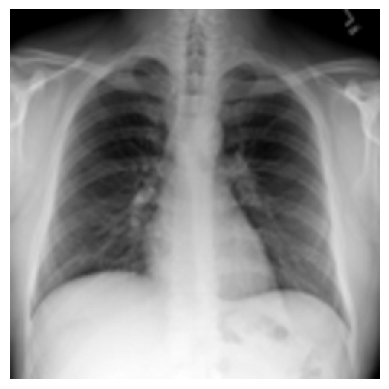

In [11]:
import matplotlib.pyplot as plt

def show_image(img, title=None, cmap='gray'):
    plt.figure()
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.show()
    
show_image(train[0], title="Sample Image")

# 잡음

## 잡음 함수
* skimage.util.random_noise
    1. skimage.util.random_noise
    https://scikit-image.org/docs/stable/api/skimage.util.html#skimage.util.random_noise
    2. 만약 위 함수 말고 numpy를 통해 noisy level을 선택하고 싶을 시
   https://theailearner.com/tag/skimage-util-random_noise/

In [13]:
def noisy(data, mode = config.noisy, var = config.var, seed=None):
    # skimage.util.random_noise를 사용하기 위해 이미지를 float로 변환
    data = img_as_float(data)

    if mode == "gauss":
        noisy_img = random_noise(data, mode='gaussian', var = var, seed=seed, clip=True)
        # 기본값: mode = gaussian, mean = 0, var = 0.01
        return noisy_img

    elif mode == "poisson":
        noisy_img = random_noise(data, mode=mode, seed=seed, clip=True)
        return noisy_img

    elif mode == "speckle":
        noisy_img = random_noise(data, mode=mode, var = var, seed=seed, clip=True)
        # 기본값: mean = 0, var = 0.01
        return noisy_img
    
    elif mode == "s&p":
        noisy_img = random_noise(data, mode=mode, amount = 0.1, salt_vs_pepper = 0.5, seed=seed, clip=True)
        # 기본값: mean = 0, var = 0.01
        return noisy_img   


## Noisy DataSet 생성

In [14]:
print(f'현재 설정된 noise mode : {config.noisy}')

현재 설정된 noise mode : speckle


In [15]:
noisy_train = noisy(train)
noisy_test = noisy(test)

print("< noisy_train_set >")
print(noisy_train.shape)
print(f"데이터 타입 : {type(noisy_train)}")

print()
print("< noisy_test_set >")
print(noisy_test.shape)
print(f"데이터 타입 : {type(noisy_test)}")

< noisy_train_set >
(8153, 256, 256)
데이터 타입 : <class 'numpy.ndarray'>

< noisy_test_set >
(2039, 256, 256)
데이터 타입 : <class 'numpy.ndarray'>


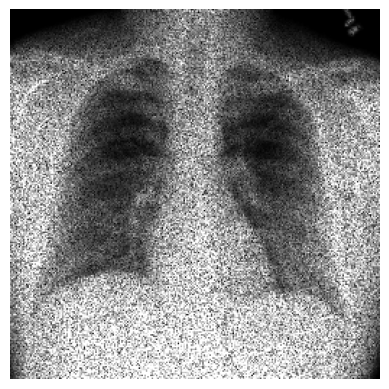

In [16]:
show_image(noisy_train[0], title="Sample Image")

# Denoising Wavelet
* skimage.restoration.denoise_wavelet
    1. 설명 : https://scikit-image.org/docs/stable/api/skimage.restoration.html
    2. 깃헙 : https://github.com/scikit-image/scikit-image/blob/v0.23.2/skimage/restoration/_denoise.py#L847-L1044
    3. 예시 : https://scikit-image.org/docs/stable/auto_examples/filters/plot_denoise_wavelet.html#sphx-glr-auto-examples-filters-plot-denoise-wavelet-py
* 옵션
    1. 해당 되는 옵션 : image, sigma, wavelet, mode, wavelet_levels, method, rescale_sigma
    2. 해당 안 되는 옵션 : conver2ycbcr, channel_axis

## 디노이징 웨이블릿 함수

In [17]:
def Denoise_WT(data):
    return (
        denoise_wavelet(data,
               wavelet=config.wt, mode=config.th, wavelet_levels=config.wt_lv,
               method=config.th_mth, rescale_sigma=config.rcl_sigma, sigma = config.sigma)
    )

## 디노이징 웨이블릿 데이터 생성

In [18]:
print(f'현재 설정된 wavelet function : {config.wt}',
      f'현재 설정된 wavelet level : {config.wt_lv}',
      f'현재 설정된 threshold mode : {config.th}',
      f'현재 설정된 threshold method : {config.th_mth}',
      f'현재 설정된 rescale sigma 여부 : {config.rcl_sigma}',
      sep = '\n')

현재 설정된 wavelet function : db4
현재 설정된 wavelet level : 2
현재 설정된 threshold mode : soft
현재 설정된 threshold method : BayesShrink
현재 설정된 rescale sigma 여부 : True


In [19]:
denoisy_train = Denoise_WT(noisy_train)
denoisy_test = Denoise_WT(noisy_test)

print("< denoisy_train_set >")
print(denoisy_train.shape)
print(f"데이터 타입 : {type(denoisy_train)}")

print()
print("< denoisy_test_set >")
print(denoisy_test.shape)
print(f"데이터 타입 : {type(denoisy_test)}")

< denoisy_train_set >
(8153, 256, 256)
데이터 타입 : <class 'numpy.ndarray'>

< denoisy_test_set >
(2039, 256, 256)
데이터 타입 : <class 'numpy.ndarray'>


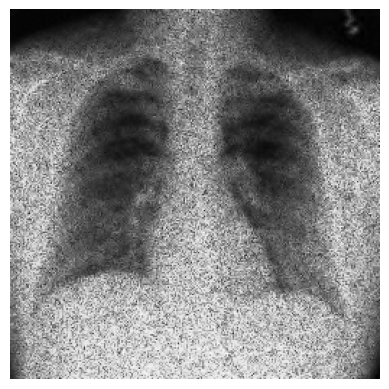

In [20]:
show_image(denoisy_train[0], title="Sample Image")

# 텐서화&표준화 및 type:np.ndarray -> DataLoader 변화

## Transform 함수

In [21]:
def Transform(data):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5)
    ])

    reform = []
    for img in data:
        reform_img = img[:, :, np.newaxis]
        reform.append(transform(reform_img))

    return (
        DataLoader(reform, batch_size=config.batch_size, shuffle=False, drop_last=True)
    )

In [22]:
real_train = Transform(train)
real_test = Transform(test)

wlow_train = Transform(denoisy_train)
wlow_test = Transform(denoisy_test)

low_train = Transform(noisy_train)
low_test = Transform(noisy_test)

print(type(real_train))

#shape
data_iter = iter(real_train)
images = next(data_iter)
print(f"Image shape: {images.shape}")

<class 'torch.utils.data.dataloader.DataLoader'>
Image shape: torch.Size([16, 1, 256, 256])


In [23]:
def PSNR(img1, img2):
    min_value = -1
    max_value = 1
    if type(img1) == torch.Tensor:
        mse = torch.mean((img1 - img2) ** 2)
    else:
        mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = max_value - min_value
    return 10 * math.log10((PIXEL_MAX ** 2) / mse)

# U-Net구조

### Deformable Convolution

In [24]:
class DeformableConv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 stride=1,
                 padding=1,
                 bias=False):

        super(DeformableConv2d, self).__init__()
        
        assert type(kernel_size) == tuple or type(kernel_size) == int

        kernel_size = kernel_size if type(kernel_size) == tuple else (kernel_size, kernel_size)
        self.stride = stride if type(stride) == tuple else (stride, stride)
        self.padding = padding
        
        self.offset_conv = nn.Conv2d(in_channels, 
                                     2 * kernel_size[0] * kernel_size[1],
                                     kernel_size=kernel_size, 
                                     stride=stride,
                                     padding=self.padding, 
                                     bias=True)

        nn.init.constant_(self.offset_conv.weight, 0.)
        nn.init.constant_(self.offset_conv.bias, 0.)
        
        self.modulator_conv = nn.Conv2d(in_channels, 
                                     1 * kernel_size[0] * kernel_size[1],
                                     kernel_size=kernel_size, 
                                     stride=stride,
                                     padding=self.padding, 
                                     bias=True)

        nn.init.constant_(self.modulator_conv.weight, 0.)
        nn.init.constant_(self.modulator_conv.bias, 0.)
        
        self.regular_conv = nn.Conv2d(in_channels=in_channels,
                                      out_channels=out_channels,
                                      kernel_size=kernel_size,
                                      stride=stride,
                                      padding=self.padding,
                                      bias=bias)

    def forward(self, x):
        #h, w = x.shape[2:]
        #max_offset = max(h, w)/4.

        offset = self.offset_conv(x)#.clamp(-max_offset, max_offset)
        modulator = 2. * torch.sigmoid(self.modulator_conv(x))
        
        x = torchvision.ops.deform_conv2d(input=x, 
                                          offset=offset, 
                                          weight=self.regular_conv.weight, 
                                          bias=self.regular_conv.bias, 
                                          padding=self.padding,
                                          mask=modulator,
                                          stride=self.stride,
                                          )
        return x

In [25]:
def init_weight(model):
    class_name = model.__class__.__name__
    if class_name.find("Conv") != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
        if model.bias is not None:
            nn.init.constant_(model.bias.data, 0)

In [26]:
def initialize_deformable_conv2d_weights(model):
    if isinstance(model, DeformableConv2d):
        nn.init.constant_(model.offset_conv.weight, 0.)
        nn.init.constant_(model.offset_conv.bias, 0.)
        nn.init.constant_(model.modulator_conv.weight, 0.)
        nn.init.constant_(model.modulator_conv.bias, 0.)
        init_weight(model.regular_conv)

def initialize_all_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            init_weight(m)
        elif isinstance(m, DeformableConv2d):
            initialize_deformable_conv2d_weights(m)



### Generator

In [27]:
class CBR2d(nn.Module):
    def __init__(self, in_channel, out_channel, normalize = True, dropout = 0.0):
        super().__init__()

        layers = []
        layers += [nn.Conv2d(in_channels = in_channel, out_channels = out_channel,
                                 kernel_size = 3, stride= 1, padding = 1,
                                 bias = False)]
        
        if normalize:
            layers.append(nn.BatchNorm2d(out_channel))
            
        layers += [nn.LeakyReLU(0.2)]

        if dropout:
            layers.append(nn.Dropout(dropout))

        self.CBR2d = nn.Sequential(*layers)

    def forward(self, x):
        x = self.CBR2d(x)
        return x
    
class DCBR2d(nn.Module):
    def __init__(self, in_channel, out_channel, normalize = True, dropout = 0.0):
        super().__init__()

        layers = []
        layers += [DeformableConv2d(in_channels = in_channel, out_channels = out_channel,
                                 kernel_size = 3, stride= 1, padding = 1,
                                 bias = False)]
        
        if normalize:
            layers.append(nn.BatchNorm2d(out_channel))
            
        layers += [nn.LeakyReLU(0.2)]

        if dropout:
            layers.append(nn.Dropout(dropout))

        self.DCBR2d = nn.Sequential(*layers)

    def forward(self, x):
        x = self.DCBR2d(x)
        return x
   

class UUp(nn.Module):
    def __init__(self, in_channel, out_channel, dropout = 0.0):
        super().__init__()

        layer = [nn.ConvTranspose2d(in_channel, out_channel,
                                   kernel_size = 4, stride = 2, padding = 1,
                                   bias = False),
                nn.BatchNorm2d(out_channel),
                nn.LeakyReLU()]

        if dropout:
            layer.append(nn.Dropout(dropout))

        self.up = nn.Sequential(*layer)

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat((x, skip), 1)
        return x
    
class END(nn.Module):
    def __init__(self, in_channel, out_channel, dropout = 0.0):
        super().__init__()

        layer = [DeformableConv2d(in_channel, out_channel,
                                   kernel_size = 3, stride = 1, padding = 1,
                                   bias = False),
                nn.Tanh()]

        if dropout:
            layer.append(nn.Dropout(dropout))

        self.up = nn.Sequential(*layer)

    def forward(self, x, y):
        x = torch.cat((x, y), 1)
        x = self.up(x)
        return x

In [28]:

class Generator(nn.Module):
    def __init__(self, in_channel = 1, out_channel = 1):
        super().__init__()    #1 * 256 * 256

        self.updcv1_1 = DCBR2d(1, 16, normalize = False)    #16 * 256 * 256
        
        self.pool1 = nn.MaxPool2d(kernel_size=2)    #16 * 128 * 128
        
        self.upcv2_1 = CBR2d(16, 64)    #64 * 128 * 128
        
        self.pool2 = nn.MaxPool2d(kernel_size=2)      #64 * 64 * 64   

        self.upcv3_1 = CBR2d(64, 128)    #128 * 64 * 64

        self.pool3 = nn.MaxPool2d(kernel_size=2)     #128 * 32 * 32   

        self.upcv4_1 = CBR2d(128, 256, dropout = 0.2)    #256 * 32 * 32
        
        self.pool4 = nn.MaxPool2d(kernel_size=2)     #256 * 16 * 16
        
        self.drop = nn.Dropout(0.2)
        
        self.upcv5_1 = CBR2d(256, 512, dropout = 0.2, normalize = False)    #512 16 * 16
        
        self.downcv5_1 = CBR2d(512, 256, dropout = 0.2, normalize = False)    #256 * 16 * 16
        
        self.up5 = UUp(256, 256, dropout = 0.2)  
        
        self.downcv4_1 = CBR2d(512, 256, dropout = 0.2)
        
        self.up4 = UUp(256, 128, dropout = 0.2)
        
        self.downcv3_1 = CBR2d(256, 128)
                
        self.up3 = UUp(128, 64)
        
        self.downcv2_1 = CBR2d(128, 64)
        
        self.up2 = UUp(64, 16)
        
        self.skip1 = DCBR2d(1, 16)
        
        self.skip2 = CBR2d(1, 16)
                
        self.end1 = END(64, 1)


    def forward(self, x):  #256
        updcv1_1 = self.updcv1_1(x)  
        pl1 = self.pool1(updcv1_1)  #128
        
        upcv2_1 = self.upcv2_1(pl1)
        pl2 = self.pool2(upcv2_1)  #64
        
        upcv3_1 = self.upcv3_1(pl2)
        pl3 = self.pool3(upcv3_1)  #32
        
        upcv4_1 = self.upcv4_1(pl3)
        pl4 = self.pool4(upcv4_1)  #16
        
        drop = self.drop(pl4)
        
        upcv5_1 = self.upcv5_1(drop)
        
        downcv5_1 = self.downcv5_1(upcv5_1)
        u5 = self.up5(downcv5_1, upcv4_1)  #32
        
        downcv4_1 = self.downcv4_1(u5) 
        u4 = self.up4(downcv4_1, upcv3_1)  #64
        
        downcv3_1 = self.downcv3_1(u4)
        u3 = self.up3(downcv3_1, upcv2_1)  #128
        
        downcv2_1 = self.downcv2_1(u3)
        u2 = self.up2(downcv2_1, updcv1_1)
        
        skip_1 = self.skip1(x)
        skip_2 = self.skip2(x)
        
        cat1 = torch.cat((skip_1, skip_2), 1)
        
        end1 = self.end1(cat1, u2)
        
        return end1


### Discriminator

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # 2 * 256 * 256 입력 이미지
            DeformableConv2d(2, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # 64 * 128 * 128
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # 128 * 64 * 64
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # 256 * 32 * 32
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # 512 * 16 * 16
            nn.Conv2d(512, 1, 3, 1, 1, bias=False),
            nn.Sigmoid()  
        )

    def forward(self, a, b):
        x = torch.cat((a, b), 1) 
        output = self.main(x)
        return output

# Training

In [30]:
wavelet_model_gen = Generator().to(device)
wavelet_model_dis = Discriminator().to(device)

In [31]:
initialize_all_weights(wavelet_model_gen)
initialize_all_weights(wavelet_model_dis)

In [32]:
wavelet_opt_gen = optim.Adam(wavelet_model_gen.parameters(), lr = 0.002, betas = (0.5, 0.999))
wavelet_opt_dis = optim.Adam(wavelet_model_dis.parameters(), lr = 0.002, betas = (0.5, 0.999))

In [33]:
loss_gan = nn.BCELoss()
loss_total = nn.L1Loss()

lambda_ = 100

In [ ]:
wavelet_model_gen.train()
wavelet_model_dis.train()

count = 0
start_time = time.time()

wavelet_loss_hist = {"gen" : [],
                     "dis" : []}
wavelet_Psnr = []
for epoch in range(config.n_epochs):
    psnr = 0
    for i, j in zip(wlow_train, real_train):
        input_size = i.size(0)

        input_img = i.to(device).float()
        real_img = j.to(device).float()

        real_label = torch.ones(input_size, 1, 16, 16).to(device)
        fake_label = torch.zeros(input_size, 1, 16, 16).to(device)
        
        wavelet_model_gen.zero_grad()

        fake_img = wavelet_model_gen(input_img)
        out_dis = wavelet_model_dis(fake_img, real_img)

        gen_loss = loss_gan(out_dis, real_label)
        pixel_loss = loss_total(fake_img, real_img)

        gen_total_loss = gen_loss + lambda_ * pixel_loss
        gen_total_loss.backward()
        wavelet_opt_gen.step()

        wavelet_model_dis.zero_grad()


        out_dis = wavelet_model_dis(real_img, input_img)
        real_loss = loss_gan(out_dis, real_label)

        out_dis = wavelet_model_dis(fake_img.detach(), input_img)
        fake_loss = loss_gan(out_dis, fake_label)

        dis_total_loss = (real_loss + fake_loss) / 2.
        dis_total_loss.backward
        wavelet_opt_dis.step()

        wavelet_loss_hist["gen"].append(gen_total_loss.item())
        wavelet_loss_hist["dis"].append(dis_total_loss.item())

        psnr += PSNR(fake_img, real_img)


        count += 1
        if count % len(real_train) == 0:
            p = psnr / len(real_train)
            print("Epoch: %.0f, Gen_total_loss: %6f, Dis_total_loss: %6f, time: %2f min, psnr: %6f"
                  %(epoch, gen_total_loss.item(), dis_total_loss.item(), (time.time()-start_time)/60, p))
    wavelet_Psnr.append(psnr / len(real_train))

# Test

In [31]:
# Wavelet GAN - Wavelet TestDataset

wavelet_model_gen.eval()

with torch.no_grad():
    for i, j in zip(wlow_test, real_test):
        wGANw_fake_img = wavelet_model_gen(i.to(device).float()).detach().cpu()
        wGANw_real_img = j
        break

In [32]:
def ps(img_set1, img_set2, wavelet = False):
    psnr = 0
    SSIM = 0

    for i in range(0, len(img_set1)):
        if wavelet == True:
            psnr += PSNR(np.array(img_set1[i].permute(1, 2, 0).squeeze(2)),
                        np.array(Denoise_WT(np.array(img_set2[i].permute(1, 2, 0).squeeze(2)))))
            SSIM += ssim(np.array(img_set1[i].permute(1, 2, 0).squeeze(2)),
                        np.array(Denoise_WT(np.array(img_set2[i].permute(1, 2, 0).squeeze(2)))))
        else:
            psnr += PSNR(np.array(img_set1[i].permute(1, 2, 0).squeeze(2)),
                        np.array(img_set2[i].permute(1, 2, 0).squeeze(2)))
            SSIM += ssim(np.array(img_set1[i].permute(1, 2, 0).squeeze(2)),
                        np.array(img_set2[i].permute(1, 2, 0).squeeze(2)))

    return (psnr/len(img_set1), SSIM/len(img_set1))

In [33]:
psnr_wGAN, ssim_wGAN = ps(wGAN_real_img, wGAN_fake_img)
psnr_wGANw, ssim_wGANw = ps(wGANw_real_img, wGANw_fake_img)

psnr_wGAN_Wavelet, ssim_wGAN_Wavelet = ps(wGAN_real_img, wGAN_fake_img, wavelet = True)
psnr_wGANw_Wavelet, ssim_wGANw_Wavelet = ps(wGANw_real_img, wGANw_fake_img, wavelet = True)


print("*-" * 30)
print("PSNR_WaveletGAN_WaveletTestData : {0:0.6f}".format(psnr_wGANw))
print("*-" * 30)
print("SSIM_WaveletGAN_WaveletTestData : {0:0.6f}".format(ssim_wGANw))
print("*-" * 30)


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
PSNR_WaveletGAN : 36.297310
PSNR_WaveletGAN_WaveletTestData : 38.298267
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
SSIM_WaveletGAN : 0.935033
SSIM_WaveletGAN_WaveletTestData : 0.954440
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
____________________  +Wavelet  ____________________
PSNR_WaveletGAN : 35.117750
PSNR_WaveletGAN_WaveletTestData : 35.093330
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
____________________  +Wavelet  ____________________
SSIM_WaveletGAN : 0.921594
SSIM_WaveletGAN_WaveletTestData : 0.930675
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-


### Test image 

In [34]:
print("Shape of wGANw_real_img:", wGANw_real_img.shape)
print("Shape of wGANw_fake_img:", wGANw_fake_img.shape)
print(wGANw_real_img[0].shape)

Shape of wGANw_real_img: torch.Size([16, 1, 256, 256])
Shape of wGANw_fake_img: torch.Size([16, 1, 256, 256])
torch.Size([1, 256, 256])


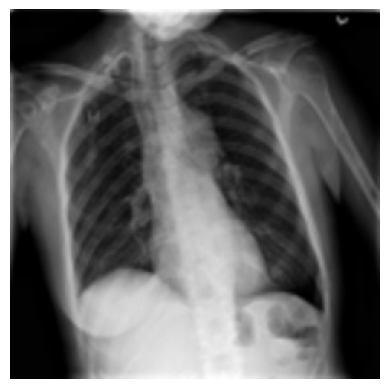

In [35]:
import matplotlib.pyplot as plt

orig_img_single = wGANw_real_img[0] 
plt.imshow(orig_img_single.permute(1, 2, 0).numpy(), cmap='gray') 
plt.axis('off')

plt.show()

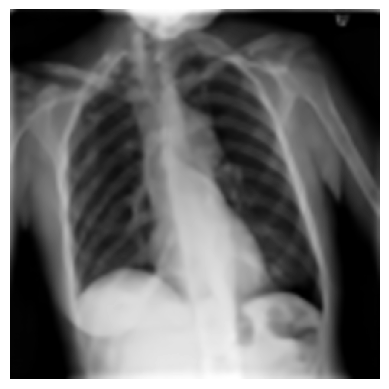

In [36]:
#Generated Image
import matplotlib.pyplot as plt

orig_img_single = wGANw_fake_img[0] 
plt.imshow(orig_img_single.permute(1, 2, 0).numpy(), cmap='gray') 

plt.axis('off')

plt.show()